## Process GIMMS PKU

paper: https://essd.copernicus.org/articles/15/4181/2023/essd-15-4181-2023.html

data: https://zenodo.org/records/8253971

In [1]:
import os
import pandas as pd
import xarray as xr
import rioxarray as rxr
import numpy as np
from datetime import datetime
from odc.geo.xr import assign_crs
import warnings
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask, round_coords 

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200468745216 due to system memory limit of 46.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45891,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:43567,Total threads: 12
Dashboard: /proxy/45763/status,Memory: 46.00 GiB
Nanny: tcp://127.0.0.1:37699,


In [8]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/gimms_pku_solely/'

In [9]:
files = [base+i for i in os.listdir(base) if i.endswith('.tif')]
files.sort()
print(len(files))

456


In [ ]:
dss=[]
i=0
for f in files:
    print(" {:02}/{:02}\r".format(i+1, len(files)), end="")
    warnings.simplefilter('ignore')
    #open and clip to Aus extent
    ds = rxr.open_rasterio(f).sel(x=slice(110,155), y=slice(-9.5,-45))
    ndvi = ds.isel(band=0)
    ndvi = (ndvi.where(ndvi<65535)*0.001) #set nans and scale

    #build qc mask
    qc = ds.isel(band=1)
    qc= qc.where(qc<65535)

    # for 'solely' version
    qc_mask = xr.where(qc==0, 1, 0) # good quality AVHRR 

    # for 'consolidated' version
    # qc_mask_0 = xr.where(qc==109, 1, 0) #random forest, good quality avhrr
    # qc_mask_1 = xr.where(qc==990, 1, 0) #random forest, good quality modis 
    # qc_mask = np.logical_or(qc_mask_0, qc_mask_1)
    
    ndvi = ndvi.where(qc_mask)

    #add time dim
    time = datetime.strptime(f[-12:-4], "%Y%m%d")
    time = np.datetime64(time)
    ndvi = ndvi.expand_dims(time=[time])

    #clean up
    ndvi = assign_crs(ndvi, crs='epsg:4326')
    ndvi.attrs['nodata'] = np.nan
    ndvi = ndvi.rename({'y':'latitude', 'x':'longitude'})
    dss.append(ndvi)
    i+=1

ds = xr.concat(dss, dim='time').sortby('time')
ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).median()

In [34]:
#combining the one I processed earlier
late = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_GIMMS-PKU_200003_201312.nc')
late = assign_crs(late, crs='epsg:4326')
late = late.rename({'__xarray_dataarray_variable__':'NDVI'})
late = late.to_array().squeeze().drop('variable')

xx = xr.concat([ds.sel(time=slice('1982', '2000-02')), late], dim='time').sortby('time')

In [79]:
# ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
xx.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc')

In [80]:
xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc')

<xarray.Dataset>
Dimensions:                        (longitude: 540, latitude: 426, time: 384)
Coordinates:
  * longitude                      (longitude) float64 110.0 110.1 ... 155.0
  * latitude                       (latitude) float64 -9.542 -9.625 ... -44.96
    spatial_ref                    int32 ...
  * time                           (time) datetime64[ns] 1982-01-15 ... 2013-...
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float32 ...

In [71]:
xx = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc')
pku_modis = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').sel(time=xx.time)

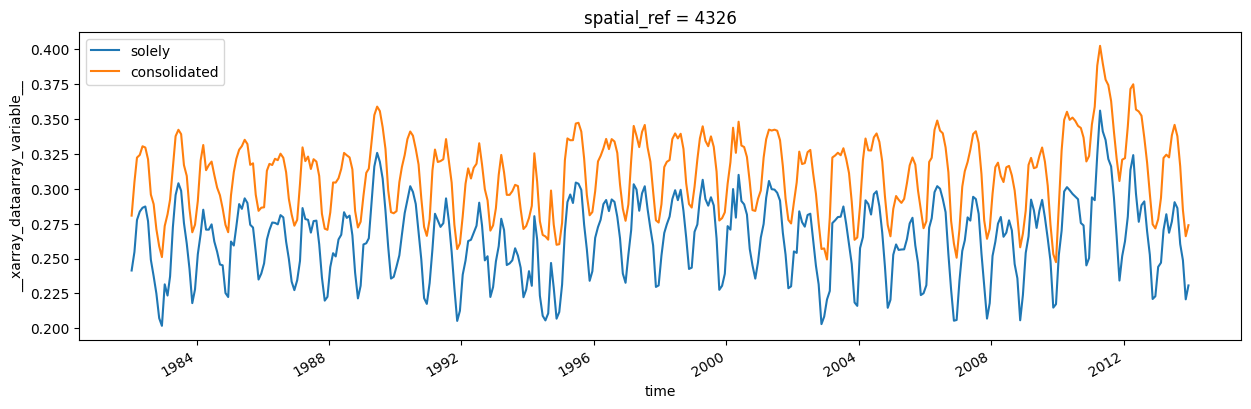

In [72]:
fig, ax = plt.subplots(1,1, figsize=(15,4))

xx.mean(['latitude','longitude']).plot(ax=ax, label='solely')
pku_modis['__xarray_dataarray_variable__'].mean(['latitude','longitude']).plot(ax=ax, label='consolidated')
ax.legend()

In [73]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
    )
    
solely_std_anom = stand_anomalies(xx)
consolidated_std_anom = stand_anomalies(pku_modis)

In [74]:
roll=12

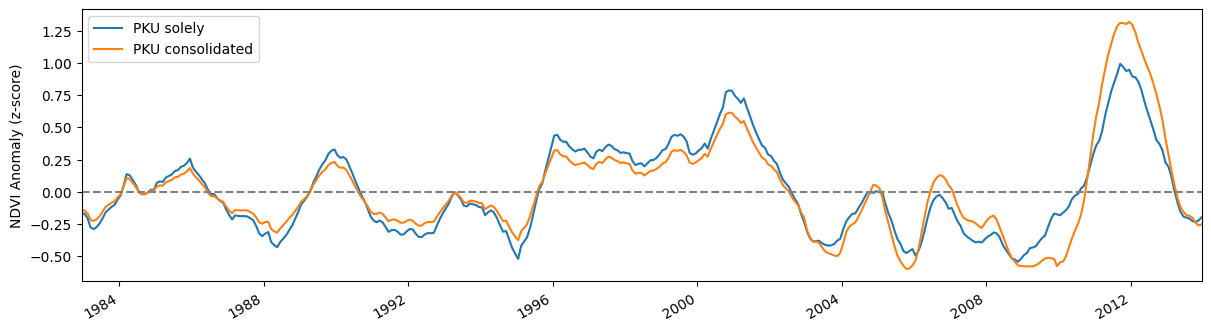

In [75]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))

solely_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['latitude','longitude']).plot(ax=ax, label='PKU solely')
consolidated_std_anom['__xarray_dataarray_variable__'].drop('month').rolling(time=roll, min_periods=roll).mean().mean(['latitude','longitude']).plot(ax=ax, label='PKU consolidated')
ax.legend()
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel('NDVI Anomaly (z-score)')
ax.set_xlabel('')
ax.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title(None);
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compare_PKU_landsat_"+str(roll)+"Mrollingmean.png",
#             bbox_inches='tight', dpi=300)

In [ ]:
# ds = ds.sel(time=slice('1982', '2022'))

## Examine ecological units

In [ ]:
import rioxarray as rxr
import xarray as xr

In [ ]:
# ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/ESA_worldcover_1km.nc')
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/climate-carbon-interactions/data/aus6_0e_mvg.tif').squeeze().drop('band')

In [ ]:
ds.plot.imshow(cmap='Paired', size=10)

In [ ]:
ds = ds.sel(x=slice(110,155), y=slice(-9.5,-45)) #aus extent

In [ ]:
ds.plot.imshow(size=10, cmap='tab20')

## Process Sami's harmonized NDVI

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import pandas as pd

ds = pd.read_parquet('/g/data/os22/chad_tmp/climate-carbon-interactions/data/MCD43_AVHRR_NDVI_hybrid_2020-10-12.parquet')

ds['date'] = pd.to_datetime(ds['date'])
ds =  ds.rename({'date':'time'}, axis=1)
ds = ds.set_index(['x','y','time'])
ds = ds.drop(['month', 'year', 'season', 'sza', 'tod'], axis=1)

ds = ds.to_xarray()
ds = ds.transpose()
ds = assign_crs(ds, crs='epsg:4326')

ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/MCD43_AVHRR_NDVI_hybrid_EasternOzWoody.nc')

In [ ]:
# ds.plot.imshow(col='time', col_wrap=4, robust=True)

## Gobal LST from AVHRR

data avilable here: http://glass.umd.edu/LST/v02/

paper here: https://essd.copernicus.org/articles/12/3247/2020/#section5


## Soil Moisture (S-GRAFS)

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import warnings
import odc.geo.xr
import xarray as xr
from odc.geo.xr import assign_crs
import pandas as pd
# import geopandas as gpd

In [ ]:
base = '/g/data/fj4/SatelliteSoilMoistureProducts/S-GRAFS/SM_vol_1km/'

In [ ]:
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from dask_utils import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
files = [base+i for i in os.listdir(base) if i.endswith('.nc')]
files.sort()
print(len(files))

In [ ]:
ds = xr.open_mfdataset(files) #chunks=dict(latitude=1000, longitude=1000)
ds = assign_crs(ds, crs='epsg:4326')
ds = ds[['soil_moisture']]
ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
ds

In [ ]:
%%time
ds = ds.compute()

In [ ]:
ds.attrs['nodata'] = np.nan

In [ ]:
gpp = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_GPP_2003_2022_5km_quantiles_v1.1.nc'), crs='epsg:4326')

ds_5k = ds.odc.reproject(how=gpp.odc.geobox, resampling='average')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/S-GRAFS_1km_monthly_2015_2022.nc')

In [ ]:
ds_5k.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/S-GRAFS_5km_monthly_2015_2022.nc')

## Fuel Moisture Content (modis)

 https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalog/ub8/au/FMC/catalog.xml

In [ ]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from odc.geo.xr import assign_crs
import warnings
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from dask_utils import start_local_dask
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [ ]:
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
# base = 'https://dapds00.nci.org.au/thredds/dodsC/ub8/au/FMC/mosaics/'
base = '/g/data/ub8/au/FMC/mosaics/'
files = [base+i for i in os.listdir(base) if i.endswith('.nc')]
files = [i for i in files if "fmc" in i]
files.sort()

In [ ]:
path = 'https://raw.githubusercontent.com/nicolasyounes/engn3903/main/figures/NSW.geojson'
gdf = gpd.read_file(path)

In [ ]:
xr.open_dataset(files[0])['lfmc_median']

In [ ]:
fmc = xr.open_mfdataset(files)['lfmc_median']
fmc = fmc.sel(longitude=slice(139,155), latitude=slice(-25,-38))
fmc = assign_crs(fmc, crs='EPSG:4326')
fmc = fmc.resample(time='MS').mean()
fmc = fmc.compute()

In [ ]:
mask = xr_rasterize(gdf, fmc.isel(time=1))
fmc_masked = fmc.where(mask)
fmc_masked = fmc_masked.dropna(dim='latitude',how='all')
fmc_masked = fmc_masked.dropna(dim='longitude',how='all')

In [ ]:
fmc_masked.mean('time').plot.imshow(robust=True)

In [ ]:
fmc_masked.to_netcdf('/scratch/du53/FMC_NSW_monthly_2001_2022.nc')

## Woody Cover Fraction (~Trees)

For the years 2000-2022 this was already processed in the `AusEFlux` repo.

We'll need to mosaic the 25m datasets to get the 90's.  This requires a ton of memory, ~300 GiB

In [ ]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
import warnings
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from dask_utils import start_local_dask
from _collect_prediction_data import round_coords

In [ ]:
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
base = '/g/data/os22/chad_tmp/AusEFlux/data/5km/WCF/'
files = [base+i for i in os.listdir(base) if i.endswith('.nc')]
files.sort()

In [ ]:
wcf = xr.open_mfdataset(files)
wcf = assign_crs(wcf, crs='EPSG:4326')
wcf = wcf.compute()
del wcf.WCF.attrs['grid_mapping']
wcf.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/WCF_5km_monthly_2000_2022.nc')

### Mosaicing the 25m tiles of WCF

In [ ]:
base = '/g/data/ub8/au/LandCover/DEA_ALC/'
years = [str(i) for i in range(2000,2022)]
tiles = [i for i in os.listdir(base)]
tiles.sort()

In [ ]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/WCF_5km_monthly_2000_2022.nc').odc.geobox

In [ ]:
for y in years:
    print(y)
    dss=[]
    i=0
    for t in tiles:
        print("  {:03}/{:03}\r".format(i + 1, len(range(0, len(tiles)))), end="")
        ds = xr.open_dataset('/g/data/ub8/au/LandCover/DEA_ALC/'+t+'/fc_metrics_'+t+'_'+y+'.nc', chunks=dict(x=4000, y=4000))
        ds = ds.transpose('y', 'x')
        ds = assign_crs(ds, crs='epsg:3577').drop('crs').to_array().squeeze().drop('variable').rename('WCF')
        dss.append(ds)
        i+=1

    warnings.filterwarnings("ignore")
    ds = xr.combine_by_coords(dss).compute()
    ds = ds.WCF
    ds.attrs['nodata'] = np.nan
    ds = ds.odc.reproject(gbox, resampling='average').compute()
    ds = round_coords(ds)
    time = pd.date_range(y+"-01", y+"-12", freq='MS') 
    time = [t+pd.Timedelta(14, 'd') for t in time]
    ds = ds.expand_dims(time=time)
    ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/WCF/WCF_'+y+'.nc')
    

### Merge the files

In [ ]:
_2000_2022 = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/WCF_5km_monthly_2000_2022.nc'), crs='EPSG:4326')
mean = _2000_2022.WCF.sel(time=slice('2000', '2010')).mean('time')
mask = np.isnan(mean)
mask = ~mask

In [ ]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/WCF/'
files = [base+i for i in os.listdir(base) if i.endswith('.nc')]
files.sort()

In [ ]:
wcf = xr.open_mfdataset(files)
wcf = wcf.rename({'__xarray_dataarray_variable__':'WCF'})
wcf = assign_crs(wcf, crs='EPSG:4326')
wcf = wcf.where(mask)
ds = xr.concat([wcf, _2000_2022], dim='time')
ds = ds.compute()

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/WCF_5km_monthly_1990_2022.nc')

In [ ]:
ds.WCF.mean(['latitude', 'longitude']).plot(figsize=(13,4));
plt.title('Mean WCF 1992-2022 ');

(ds.WCF.sel(time=slice('2018','2022')).mean('time') - ds.WCF.sel(time=slice('1990','1994')).mean('time')).plot.imshow(size=7, robust=True, cmap='RdBu')
plt.title('Difference WCF: 2018-2022 average minus 1990-94 average');

### Extend WCF back to the 80's

In [ ]:
import xarray as xr

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc')
ds = ds.sel(time=slice('1990','2022'))

time= xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc').time
time=time.sel(time=slice('1982', '1989'))

dss = ds.isel(time=range(0,60)).mean('time')
dss = dss.expand_dims(time=time)

In [ ]:
ds_out = xr.concat([dss, ds], dim='time').sortby('time')

In [ ]:
ds_out.WCF.mean(['latitude', 'longitude']).plot(figsize=(11,5))

In [ ]:
(ds_out/100).to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc')

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc')

## VegH

In [ ]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
import warnings
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

In [ ]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc').odc.geobox
time= xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc').time

In [ ]:
ds = xr.open_dataarray('//g/data/os22/chad_tmp/NEE_modelling/data/1km/VegH_1km_monthly_2002_2022.nc').isel(time=0).drop('time')

In [ ]:
ds = ds.odc.reproject(gbox, resampling='average').compute()
ds = round_coords(ds)
ds = ds.expand_dims(time=time)

In [ ]:
ds = assign_crs(ds, crs='EPSG:4326')
ds = ds.rename({'__xarray_dataarray_variable__':'VegH'})
del ds.VegH.attrs['grid_mapping']
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/VegH_5km_monthly_1982_2022.nc')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/VegH_5km_monthly_1982_2022__.nc')

## ANUCLIM 1982-2022

Including fractional anomalies

https://dapds00.nci.org.au/thredds/catalogs/gh70/catalog.html

In [ ]:
import xarray as xr
import rioxarray
from datetime import datetime
import pandas as pd
import numpy as np
import os
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').odc.geobox

In [ ]:
base='/g/data/gh70/ANUClimate/v2-0/stable/month/'
var =  'rain' #'tavg' # # 'vpd' 'srad'

years = [str(i) for i in range(1981,2023)]

i=0
pp = []
for y in years:
    print(" {:02}/{:02}\r".format(i + 1, len(years)), end="")
    ds = xr.open_mfdataset([base+var+'/'+y+'/'+i for i in os.listdir(base+var+'/'+y+'/')],
                              chunks=dict(lat=1000, lon=1000))
    
    ds = assign_crs(ds, crs='epsg:4283') #GDA94
    ds = ds.drop('crs')[var]
    ds.attrs['nodata'] = np.nan
    ds = ds.odc.reproject(gbox, resampling='average')
    ds = round_coords(ds)
    pp.append(ds)
    i+=1

ds = xr.concat(pp, dim='time').sortby('time')
ds = ds.compute()
ds = ds.rename(var)
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1981.nc')

### ANUClim bonus datasets from 2022

Provided directly by Tingbao

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
from datetime import datetime
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
var='vpd'

In [ ]:
base='/g/data/os22/chad_tmp/climate-carbon-interactions/data/anuclim/'+var+'/'
files = [base+i for i in os.listdir(base) if i.endswith('.tif')]
files.sort()

In [ ]:
dss=[]
for i in files:
    ds = rioxarray.open_rasterio(i).squeeze().drop('band')
    time = datetime.strptime(i[-10:-4]+'15', "%Y%m%d")
    time = np.datetime64(time)
    ds = ds.expand_dims(time=[time])
    ds = ds.where(ds>-99)
    ds = assign_crs(ds, crs='epsg:4283') #GDA94
    ds.attrs['nodata'] = np.nan
    dss.append(ds)
    
ds = xr.concat(dss, dim='time').sortby('time')

In [ ]:
da = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1982_2022.nc')[var], crs='epsg:4326')
ds = ds.odc.reproject(da.odc.geobox, resampling='average')

ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])

ds = xr.concat([da, ds], dim='time').sortby('time')

In [ ]:
del ds.attrs['grid_mapping']

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1982_202212.nc')

### Cumulative rainfall

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
# from datacube.utils.dask import start_local_dask
# client = start_local_dask(mem_safety_margin='2Gb')
# client

In [ ]:
# rain = xr.open_dataarray('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_202212.nc',
#                         chunks=dict(latitude=300, longitude=300))

#use CHIRPS instead?
rain = xr.open_dataarray('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_202212.nc',
                        chunks=dict(latitude=300, longitude=300))

In [ ]:
rain_cml_3 = rain.rolling(time=3, min_periods=3).sum()
rain_cml_3 = rain_cml_3.rename('rain_cml3').sel(time=slice('1982','2022'))


In [ ]:
rain_cml_6 = rain.rolling(time=6, min_periods=6).sum()
rain_cml_6 = rain_cml_6.rename('rain_cml6').sel(time=slice('1982','2022'))

In [ ]:
rain_cml_12 = rain.rolling(time=12, min_periods=12).sum()
rain_cml_12 = rain_cml_12.rename('rain_cml12').sel(time=slice('1982','2022'))


In [ ]:
rain_cml_3.compute().to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_cml3_CHIRPS_5km_monthly_1982_202212.nc')

In [ ]:
rain_cml_6.compute().to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_cml6_CHIRPS_5km_monthly_1982_202212.nc')

In [ ]:
rain_cml_12.compute().to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_cml12_CHIRPS_5km_monthly_1982_202212.nc')

In [ ]:
rain_cml_12.mean(['latitude', 'longitude']).plot(figsize=(11,4))

### Fractional anomalies

obs / climatology (climatology goes from 1982-2012)

NDVI, rain_cml3, rain_cml6, rain_cml12, srad, tavg

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
var = 'NDVI'
ds = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1982_2022.nc'), crs='EPSG:4326')

In [ ]:
mean = ds.sel(time=slice('1982', '2012')).groupby("time.month").mean("time")

In [ ]:
frac = ds.groupby("time.month") / mean

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(17,6))
# (ds[var].mean(['latitude', 'longitude'])).plot(ax=ax)
frac[var].mean(['latitude', 'longitude']).plot(label='anomaly', ax=ax)
ax.grid(which='both')

In [ ]:
frac.drop('month').rename({var:var+'_anom'}).to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_anom_5km_monthly_1982_2022.nc')

## Fractional Cover Landsat

Curerently using annual median FC, and simpy copying the annual layer into each month

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from datacube.utils import masking

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/1km/FractionalCover_1km_annual_1987_2022.nc',
                        chunks=dict(x=300, y=300))

# ds = masking.mask_invalid_data(ds)
ds = ds.where(ds<255)

In [ ]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').odc.geobox
time = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc').time
mask = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').isel(time=0)
mask = ~np.isnan(mask.rain)

In [ ]:
ds.attrs['nodata'] = np.nan
ds = ds.odc.reproject(gbox, resampling='average')
ds = round_coords(ds)

In [ ]:
ds = ds.compute()
ds = ds.where(ds<255)

In [ ]:
dss = []
for y in range(1987, 2023):
    y = str(y)
    xx = ds.sel(time=y+'-07').squeeze().drop('time')
    xx = xx.expand_dims(time=time.sel(time=y))
    
    dss.append(xx)


In [ ]:
ds = xr.concat(dss, dim='time').sortby('time')
ds = ds.where(mask)

In [ ]:
# Gap fill with climatology
#compute climatology
clim = ds.groupby("time.month").mean("time")

#fill remaining gaps with climatology
ds = ds.groupby("time.month").fillna(clim)

In [ ]:
ds= ds.drop('month')

In [ ]:
pv = ds.pv_pc_50.rename('PV')
npv = ds.npv_pc_50.rename('NPV')
bs = ds.bs_pc_50.rename('BS')

In [ ]:
pv.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/PV_5km_monthly_1987_2022.nc')
npv.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NPV_5km_monthly_1987_2022.nc')
bs.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/BS_5km_monthly_1987_2022.nc')

### Extend to 1982

In [ ]:
import xarray as xr

In [ ]:
var='NPV'

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1987_2022.nc')

time= xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc').time
time=time.sel(time=slice('1982', '1986'))

dss = ds.isel(time=range(0,60)).mean('time')
dss = dss.expand_dims(time=time)

In [ ]:
ds_out = xr.concat([dss, ds], dim='time').sortby('time')

In [ ]:
ds_out[var].mean(['latitude', 'longitude']).plot(figsize=(11,5))

In [ ]:
ds_out.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1982_2022.nc')

## AVHRR LST

from GLASS: http://www.glass.umd.edu/Download.html

I needed to use the `dea/20230710` module to load the HDF5 files

Need to install wget to dl the files

**NOTE**: while the below works, its so bloody slow I resorted to manually downloading all the files using 'downthemall'

`pip install -v --no-binary :all: --upgrade-strategy only-if-needed --prefix /g/data/os22/chad_tmp/climate-carbon-interactions/envs/EXTRA_PYTHON_LIBS wget`

`export PYTHONPATH=/g/data/os22/chad_tmp/climate-carbon-interactions/envs/EXTRA_PYTHON_LIBS/lib/python3.8/site-packages`

In [ ]:
import os
import requests
import datetime
import pandas as pd
import numpy as np
import xarray as xr
from bs4 import BeautifulSoup

import sys
sys.path.insert(1, '/g/data/os22/chad_tmp/climate-carbon-interactions/envs/EXTRA_PYTHON_LIBS/lib/python3.8/site-packages')
import wget
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

### Download the data over http

In [ ]:
base_url = 'http://www.glass.umd.edu/LST/v02/Tang/'
year = [str(y) for y in range(1982,2014)]
out_loc = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/AVHRR_LST/'

for y in year:
    print(y)
    #where the data is listed for a given year
    url = base_url+y+'/'
    
    #get all relevant links for that year
    soup = BeautifulSoup(requests.get(url).content, "html.parser")
    files_to_dl = []
    for link in soup.select('a[href*=".hdf"]'):
        files_to_dl.append(link["href"])
    
    #strip o
    files_to_dl = [i for i in files_to_dl if i.endswith('.hdf')]

    #create folder if necessary
    if os.path.exists(out_loc+y):
        pass
    else:
        os.mkdir(out_loc+y)
    
    #download links
    i=0
    for filename in files_to_dl:
        print("  {:03}/{:03}\r".format(i + 1, len(range(0, len(files_to_dl)))), end="")
        
        if os.path.exists(out_loc+y+'/'+filename):
            i+=1
            continue
        
        else:
            try:
                wget.download(url=base_url+y+'/'+filename,
                  out=out_loc+y+'/')
            except:
                continue
            i+=1


### Open, process and concatenate files

In [ ]:
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from dask_utils import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').odc.geobox

In [ ]:
# Process AVHRR into monthly mean LST etc
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/AVHRR_LST/'
year = [str(y) for y in range(1982,1983)]

for y in year:
    print(y)

    path = base+y+'/'
    files = [path+i for i in os.listdir(path) if i.endswith('.hdf')]
    files.sort()
    
    i=0
    arrs=[]
    for f in files:
        print(" {:03}/{:03}\r".format(i + 1, len(files)), end="")
        ds = xr.open_dataset(f, engine='rasterio', chunks={}).squeeze().drop('band')
        ds = ds[['LST', 'UTC', 'VZA']]
        dt = datetime.datetime.strptime(y+' '+f[-15:-12], '%Y %j').strftime('%Y-%m-%d')
        dt = np.datetime64(dt)
        ds = ds.expand_dims(time=[dt])
        ds = assign_crs(ds, crs=ds.spatial_ref.attrs['crs_wkt'])
        ds = ds.sel(x=slice(110,155), y=slice(-9,-45)) #aus extent
        ds = ds.astype('float32')
        arrs.append(ds)
        i+=1

    dss = xr.concat(arrs, dim='time').sortby('time')
    dss.attrs['nodata'] = np.nan
    dss = dss.odc.reproject(how=gbox, resampling='bilinear').compute()
    
    #compute stats
    ds_median = dss.resample(time='MS', loffset=pd.Timedelta(14, 'd')).median()
    ds_median = ds_median.rename({'LST':'LST_median', 'UTC':'TIMEOFDAY_median', 'VZA':'VZA_median'})
    ds_median.attrs['nodata'] = np.nan
    
    lst_std = dss['LST'].resample(time='MS', loffset=pd.Timedelta(14, 'd')).std()
    lst_std = lst_std.rename('LST_stddev').to_dataset()
    lst_std.attrs['nodata'] = np.nan
       
    count = (~np.isnan(dss['LST']))
    count =  count.resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum()
    count = count.rename('n_obs').to_dataset()

    #export
    ds_out = xr.merge([ds_median, lst_std, count])
    ds_out= ds_out.astype('float32')

    ds_out.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/LST/AVHRR_LST_'+y+'.nc')
    

### Combine annual files into one file

In [ ]:
import os
import xarray as xr

In [ ]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/LST/'
files = [base+i for i in os.listdir(base) if i.endswith('.nc')]
files.sort()

In [ ]:
ds = xr.open_mfdataset(files)
ds

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/LST_harmonization/AVHRR_LST_5km_monthly_1982_2013.nc')

In [ ]:


# ds_out.LST_median.plot.imshow(col='time', col_wrap=4, robust=True)

## Terrain attributes

In [ ]:
import richdem as rd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from odc.geo.xr import wrap_xr
from odc.geo.xr import assign_crs

In [ ]:
ds = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc'), crs='EPSG:4326')

In [ ]:
arr = ds['elevation'].isel(time=0).values
arr = rd.rdarray(arr, no_data=np.nan)

In [ ]:
slope = rd.TerrainAttribute(arr, attrib='slope_riserun')
aspect = rd.TerrainAttribute(arr, attrib='aspect')

In [ ]:
aspect = wrap_xr(aspect, gbox=ds.odc.geobox)
slope = wrap_xr(slope, gbox=ds.odc.geobox)

In [ ]:
aspect = aspect.expand_dims(time=ds.time).rename('aspect')

In [ ]:
aspect.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Aspect_5km_monthly_1982_2022.nc')

## Land surface temperature minus air temperature


In [ ]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from odc.geo.xr import assign_crs

In [ ]:
tair = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/tavg_5km_monthly_1982_2022.nc')

lst = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/LST_5km_monthly_1982_2022.nc')

In [ ]:
tair = assign_crs(tair, crs='epsg:4326')
lst = assign_crs(lst, crs='epsg:4326')

In [ ]:
deltaT = (lst['LST']) - tair['tavg']
deltaT.name = 'LST-Tair'

In [ ]:
# deltaT.isel(time=-6).plot.imshow(size=6, robust=True)

In [ ]:
deltaT.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/LST_Tair_5km_monthly_1982_2022.nc')

## Landcover

This landcover dataset is the ESA WorldCover + GFSAD cropping merged together.
The values in the dataset refer to the following:

10 == trees (including mangroves)

20 == shrubland (including wetlands)

30 == grassland

40 = cropland (from GFSAD)

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import numpy as np

In [ ]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/Landcover_5km_monthly_2002_2021.nc').isel(time=1).drop('time')

gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Aspect_5km_monthly_1982_2022.nc').odc.geobox
time = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc').time

In [ ]:
ds.attrs['nodata'] = np.nan
ds = ds.odc.reproject(gbox, resampling='nearest')

In [ ]:
ds = ds.where(ds>0)

In [ ]:
ds = ds.expand_dims(time=time).rename('Landcover')
ds = ds.astype('int16')
ds = xr.where(ds>0, ds, -99)

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Landcover_5km_monthly_1982_2022.nc')

## AVHRR NDVI

Started doing this by downloading directly the global daily netcdfs from the links below, then processing them. But swithced to using GEE instead. 

from here: https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/

description: https://climatedataguide.ucar.edu/climate-data/ndvi-normalized-difference-vegetation-index-noaa-avhrr

THREDDS: https://www.ncei.noaa.gov/thredds/catalog/cdr/ndvi/catalog.html

In [ ]:
# import os
# import wget
# import requests
# from bs4 import BeautifulSoup

# base_url = 'https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/'
# year = [str(y) for y in range(1982,2014)]
# out_loc = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/AVHRR/'

# for y in year:
#     print(y)
#     #where the data is listed for a given year
#     url = "https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/"+y
    
#     #get all relevant links for that year
#     soup = BeautifulSoup(requests.get(url).content, "html.parser")
#     files_to_dl = []
#     for link in soup.select('a[href*=".nc"]'):
#         files_to_dl.append(link["href"])
    
#     #create folder if necessary
#     if os.path.exists(out_loc+y):
#         pass
#     else:
#         os.mkdir(out_loc+y)
    
#     #download links
#     i=0
#     for filename in files_to_dl:
#         print("  {:03}/{:03}\r".format(i + 1, len(range(0, len(files_to_dl)))), end="")
        
#         if os.path.exists(out_loc+y+'/'+filename):
#             i+=1
#             continue
        
#         else:
#             wget.download(url=base_url+y+'/'+filename,
#                   out=out_loc+y+'/')
#             i+=1

# ------------------------------------------------------------------------------
# #Parallel version of the above...not faster due to band width limits on ARE

# import multiprocessing as mp
# from tqdm import tqdm

# def _parallel_dl(filename, y, base_url, out_loc):
#     wget.download(url=base_url+y+'/'+filename,
#                   out=out_loc+y+'/')

# #download each link
# def update(*a):
#     pbar.update()      

# for y in year:
#     print(y)
#     #where the data is listed for a given year
#     url = "https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/"+y
    
#     #get all relevant links for that year
#     soup = BeautifulSoup(requests.get(url).content, "html.parser")
#     files_to_dl = []
#     for link in soup.select('a[href*=".nc"]'):
#         files_to_dl.append(link["href"])
    
#     if os.path.exists(out_loc+y):
#         pass
#     else:
#         os.mkdir(out_loc+y)
    
#     pbar = tqdm(total=len(files_to_dl))

#     with mp.Pool(ncpus) as pool:
#         for filename in files_to_dl:
#             pool.apply_async(
#                 _parallel_dl,
#                     [filename,
#                      y, 
#                      base_url,
#                      out_loc
#                     ],
#                 callback=update,
#                 )
#         pool.close()
#         pool.join()
#         pbar.close()

# ---------------------------------------------------------------------------
# # Process AVHRR into monthly mean NDVI

# base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/AVHRR/1982/'

# files = [base+i for i in os.listdir(base) if i.endswith('.nc')]
# files.sort()

# warnings.filterwarnings("ignore")
# ds = xr.open_mfdataset(files) #chunks=dict(latitude=1000, longitude=1000)

# ds = assign_crs(ds, ds.crs.attrs['epsg_code'])
# ds = ds.drop(['crs', 'lat_bnds', 'lon_bnds'])
# ds = ds.sel(longitude=slice(110,155), latitude=slice(-9,-45)) #aus extent

# ds = ds.compute()

# #QA masking
# flag_keys = ds.QA.flag_meanings.split()
# qa_dict = dict(zip(flag_keys, ds.QA.flag_masks))

# clouds = np.bitwise_and(ds['QA'], qa_dict['cloudy'])
# clouds = xr.where(clouds>0, 1, 0).astype(bool) #equals 1 where cloudy
# cloud_shadows = np.bitwise_and(ds['QA'], qa_dict['cloud_shadow'])
# cloud_shadows = xr.where(cloud_shadows>0, 1, 0).astype(bool)  #equals 1 where cloud_shadow

# mask = (clouds | cloud_shadows) #combine

# ds = ds.where(~mask)

# ds = ds.NDVI.resample(time='MS').mean()

# ds = assign_crs(ds, crs='epsg:4326')
# del ds.attrs['grid_mapping']

# ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/AVHRR/AVHRR_cdr_NDVI_monthly_1982.nc')

## Join landfill facilities with remoteness

In [ ]:
import geopandas as gpd
import pandas as pd

In [ ]:
waste_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/notebooks/misc/waste_management_facilities_database.geojson'
shape_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/notebooks/misc/RA_2021_AUST_GDA2020.shp'

gdf_waste = gpd.read_file(waste_path)
gdf_remote = gpd.read_file(shape_path)

gdf_remote = gdf_remote.to_crs('epsg:4326')
gdf_remote = gdf_remote[['RA_CODE21','RA_NAME21','geometry']]

gdf_waste = gdf_waste.sjoin(gdf_remote, how="left").drop('index_right', axis=1)
# gdf_waste.explore('RA_NAME21', cmap='magma')

In [ ]:
# gdf_waste.to_file('/g/data/os22/chad_tmp/climate-carbon-interactions/notebooks/misc/waste_management_facilities_database_RA2021.geojson')
# gdf_remote.to_file('/g/data/os22/chad_tmp/climate-carbon-interactions/notebooks/misc/RA_2021_AUST_GDA2020.geojson')
# gdf_waste.drop('geometry',axis=1).to_excel('/g/data/os22/chad_tmp/climate-carbon-interactions/notebooks/misc/waste_management_facilities_database_RA2021.xlsx')